My project is face mask detection system built with TensorFlow using Deep
Learning and Computer Vision concepts in order to detect face masks in static
images. The challenge is to create accurate and computationally efficient model that
can be used in real time applications. 

The project was created in 2021 during my master's studies.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import os
import cv2

from tensorflow.keras.preprocessing import image as preprocessing
from tensorflow.keras.applications import MobileNetV2 as mobilenet
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing and Visualization

The dataset comprises approximately 4,000 images categorized into two classes: 'with mask' and 'without mask.' These images consist of real faces wearing masks and were sourced from Kaggle competitions and the RMFD dataset.

In [2]:
count_mask = 0
count_w_mask = 0

for imagePath in paths.list_images(os.path.join(os.getcwd(), 'dataset')):
    label = imagePath.split(os.path.sep)[-2]
    
    if label == 'with_mask':
        count_mask += 1
    elif label == 'without_mask':
        count_w_mask += 1
    else:
        print('Invalid label:', label)

print('Number of images with mask:', count_mask)
print('Number of images without mask:', count_w_mask)

Number of images with mask: 2162
Number of images without mask: 1930


The dataset consists of $2162$ images with masks and $1930$ images without masks. Now, let's retrieve the list of images from our dataset directory, extract labels, and load the images. Additionally, we resize the images to $224 x 224$ and scale them using the 'preprocess_input' function.

In [3]:
data = []
labels = []
#Loop over imagepath to extract classlabel and load input image
for imagePath in paths.list_images(os.path.join(os.getcwd(),'dataset')):
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    # load the input image (224x224) and preprocess it
    image = preprocessing.load_img(imagePath, target_size=(224, 224))
    image = preprocessing.img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

In [4]:
print(len(data))
print(len(labels))

4092
4092


In [5]:
data[0].shape

(224, 224, 3)

In [6]:
# Conver our training data to NumPy array format 
data = np.array(data, dtype="float64")
labels = np.array(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


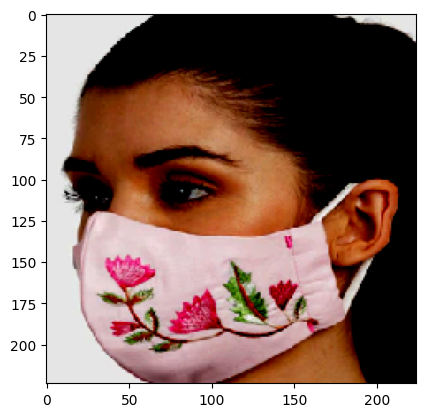

In [7]:
# Example of our images
plt.imshow(data[10])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


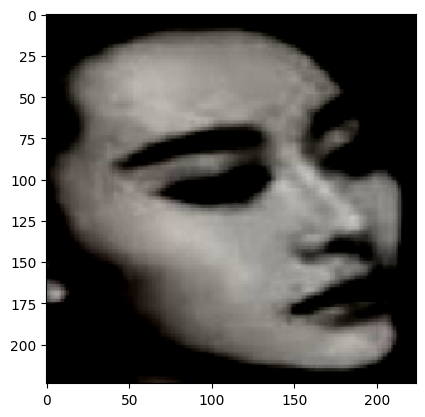

In [8]:
plt.imshow(data[2444])
plt.show()

In [9]:
data[10]

array([[[ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922],
        ...,
        [ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922]],

       [[ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922],
        ...,
        [ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922]],

       [[ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922],
        ...,
        [ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922],
        [ 0.89803922,  0.89803922,  0.89803922]],

       ...,

       [[ 0.89803922,  0.89803922,  0.89803922],
        [ 0

In [10]:
labels[10]

'with_mask'

In [11]:
print(type(data[10]))
print(type(labels[10]))

<class 'numpy.ndarray'>
<class 'numpy.str_'>


From the information above, we observe that our images are in the appropriate NumPy array format, with dimensions of $(224 \times 224 \times 3)$ in the RGB color model.

Now, we will encode our labels.

In [12]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

We split the data into training and testing sets, using $80\%$ of the data for training and the remaining $20\%$ for testing.

In [13]:
train_data_images, test_data_images, train_data_labels, test_data_labels = train_test_split(data,
                                    labels,test_size=0.20, stratify=labels, random_state=42)

In [14]:
len(test_data_labels)

819

Next, we will construct the training image generator for data augmentation since our dataset is quite small.

In [16]:
data_augmentation = preprocessing.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',                 
)

## Model preparation

During training, we'll use data augmentation, consisting of random rotation, zoom, shear, shift, and flip. Typically, data augmentations are employed to improve generalization.


Now load MobileNet with pre-trained ImageNet weights and leave off head of the network. This approach is current standard in transfer learning setting if we want to produce accurate model.

In [17]:
baseModel = mobilenet(weights="imagenet", include_top=False, input_tensor=layers.Input(shape=(224, 224, 3)))

Construct the head of the model that will be placed on top.

In [18]:
headModel = baseModel.output
headModel = layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(128, activation="relu")(headModel)
headModel = layers.Dropout(0.5)(headModel)
headModel = layers.Dense(2, activation="softmax")(headModel)

In [19]:
model = Model(inputs=baseModel.input, outputs=headModel)

Above model will be the actual model we will train. Now we will freeze the weights of base layers of the network, since we don't want to update them during backpropagation, only head layer weights will be updated.

In [20]:
for layer in baseModel.layers:
    layer.trainable = False

## Model Training

Let's establish some hyperparameters.

In [21]:
init_lr = 1e-3
epochs = 10
batch_size = 32
# Function for dynamically setting the learning rate
def lr_schedule(epoch, lr):
    decay = init_lr / epochs
    return lr - decay

We will use the Adam optimizer equipped with a learning rate decay schedule and binary cross-entropy loss.

In [22]:
opt = Adam(learning_rate=init_lr)  
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

We are ready fot training.

In [60]:
training = model.fit(data_augmentation.flow(train_data_images, train_data_labels, batch_size=batch_size),
                     steps_per_epoch=len(train_data_images) // batch_size, 
                     validation_data=(test_data_images, test_data_labels),
                     validation_steps=np.ceil(len(test_data_images) / batch_size), 
                     epochs=epochs, callbacks=[lr_scheduler])



Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000474974513.
Epoch 1/10
102/102 [==============================] - 29s 272ms/step - loss: 0.1537 - accuracy: 0.9485 - val_loss: 0.0601 - val_accuracy: 0.9805 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0008000000427477061.
Epoch 2/10
102/102 [==============================] - 28s 276ms/step - loss: 0.0666 - accuracy: 0.9787 - val_loss: 0.0376 - val_accuracy: 0.9927 - lr: 8.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000700000037997961.
Epoch 3/10
102/102 [==============================] - 31s 299ms/step - loss: 0.0473 - accuracy: 0.9824 - val_loss: 0.0379 - val_accuracy: 0.9915 - lr: 7.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0006000000332482159.
Epoch 4/10
102/102 [==============================] - 33s 324ms/step - loss: 0.0487 - accuracy: 0.9840 - val_loss: 0.0390 - val_accuracy: 0.9902 - lr: 6.0000e-04

Epoch 5: LearningRateScheduler s

## Model Evaluation

Now, grab the indices of the highest probability class labels in order to evaluate the resulting model on the test set and print the classification report.

In [61]:
predIdxs = model.predict(test_data_images, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)

26/26 [==============================] - 5s 197ms/step


In [62]:
print(classification_report(test_data_labels.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       433
           1       0.99      0.99      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819



Classification report ensures us that our model is very good in terms of prediction metrics. Next, we plot accuracy and loss during epochs to observe the model's behavior.

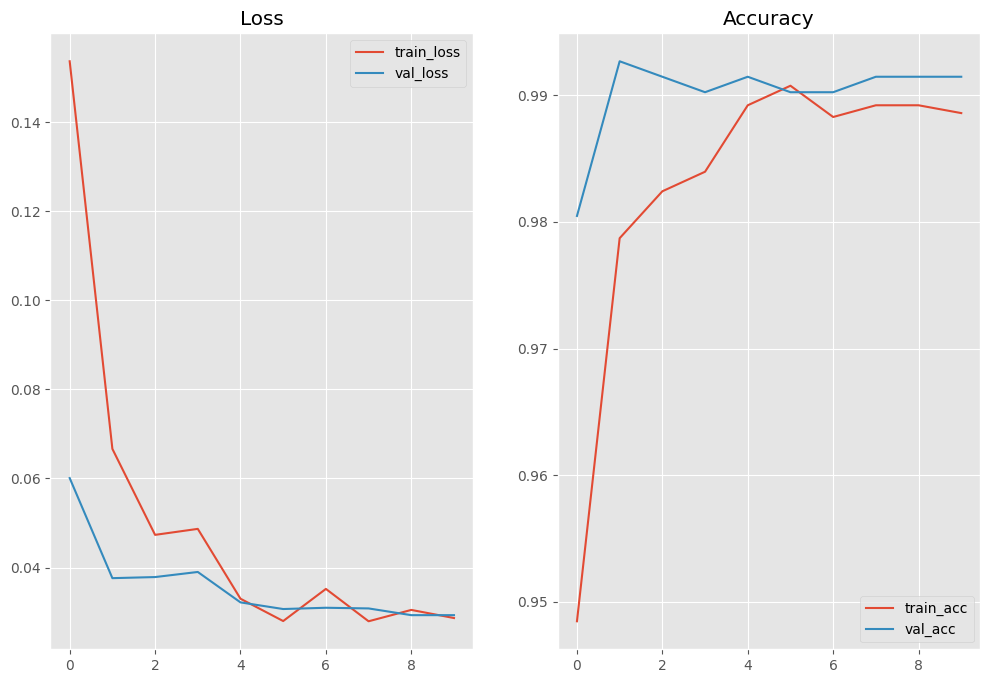

In [63]:
plt.style.use("ggplot")
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].plot(np.arange(0, epochs), training.history["loss"], label="train_loss")
axs[0].plot(np.arange(0, epochs), training.history["val_loss"], label="val_loss")
axs[0].set_title("Loss")
axs[0].legend(loc="upper right")

axs[1].plot(np.arange(0, epochs), training.history["accuracy"], label="train_acc")
axs[1].plot(np.arange(0, epochs), training.history["val_accuracy"], label="val_acc")
axs[1].set_title("Accuracy")
axs[1].legend(loc="lower right");

From the above plot, we obtained around $99\%$ accuracy on the test set at the end of the training. Moreover, our model exhibited very good results in the early epochs, and both training and test losses are also in good shape with no signs of overfitting. There is no need for hyperparameter tuning. MobileNetV2 is an accurate and computationally efficient model for vision applications; we achieved very good accuracy in just 10 epochs. It's challenging to obtain 'not good' results when using it for such tasks. We want to emphasize that we employed data augmentation and a pretrained model on ImageNet, which provided a strong boost to performance and regularization effects. Instead of aiming for more accuracy with the risk of possible overfitting, we will focus on implementing a function that applies our model to new images.

## Applying to new data

Save our model for later use.

In [31]:
model.save('Mobile_Net', save_format="h5")

Below, we implement a function for recognizing whether new images contain a mask or not by applying our model and face detector.

In [23]:
def predict_mask(image_location, model_location, treshold):
    #Face Mask Detector model (we need to localize faces prior to classifying them)
    prototxtPath = os.path.join(os.getcwd(),'face_detector', 'deploy.prototxt')
    weightsPath = os.path.join(os.getcwd(),'face_detector', 'res10_300x300_ssd_iter_140000.caffemodel')
    net = cv2.dnn.readNet(prototxtPath, weightsPath)
    model = load_model(model_location)
    #load the input image from disk
    image = cv2.imread(image_location)
    if image is None:
        return
    orig = image.copy()
    #spatial dimensions
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
    #blob -> network and obtain the face detections
    net.setInput(blob)
    detections = net.forward()
    for i in range(0, detections.shape[2]):
        #probability associated with the detection
        confidence = detections[0, 0, i, 2]
        # remove weak detections <= treshold
        if confidence > treshold:
            #bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            #Image preprocessing
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = preprocessing.img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            #determine if the face has mask
            (mask, withoutMask) = model.predict(face)[0]
            #class label and color
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            #display bounding boxes
            cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    #write new images to `facemask_detector/cv2_testing/results`
    cv2.imwrite(os.path.join(os.getcwd(),'cv2_testing', 'results', image_location.split('/')[-1]), image)
    cv2.imshow("Output", image)
    #close pop-up window by pressing 0
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Below we have some examples to test our function (images for that part are located at `facemask_detector/cv2_testing/` with results at `facemask_detector/cv2_testing/results`)

In [24]:
for image in os.listdir(os.path.join(os.getcwd(),'cv2_testing')):
    predict_mask(os.path.join(os.getcwd(),'cv2_testing', image),
                 os.path.join(os.getcwd(), 'Mobile_Net'), 0.5)

1/1 [==============================] - 0s 350ms/step


2023-10-06 19:50:35.787 Python[16146:935260] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 315ms/step


Below, we have an example output from the function above.

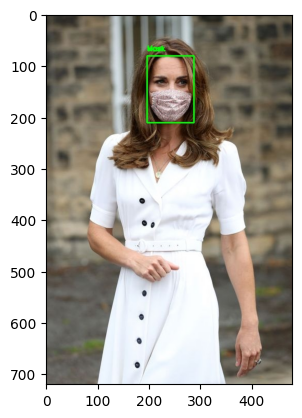

In [25]:
image = cv2.imread(os.path.join(os.getcwd(),'cv2_testing', 'results', '4.jpg'))
plt.imshow(image[:, :, ::-1])
plt.show()

Let's also evaluate the model's performance by testing it on images featuring the dean's office staff, available on the university's website. This will allow us to assess its effectiveness in detecting masks in specific real-world scenarios.

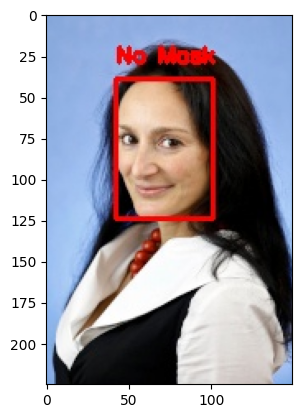

In [26]:
image = cv2.imread(os.path.join(os.getcwd(),'cv2_testing', 'results', 'dziekan3.jpg'))
plt.imshow(image[:, :, ::-1])
plt.show()

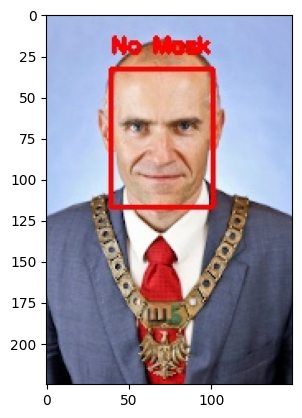

In [27]:
image = cv2.imread(os.path.join(os.getcwd(),'cv2_testing', 'results', 'dziekan2.jpg'))
plt.imshow(image[:, :, ::-1])
plt.show()

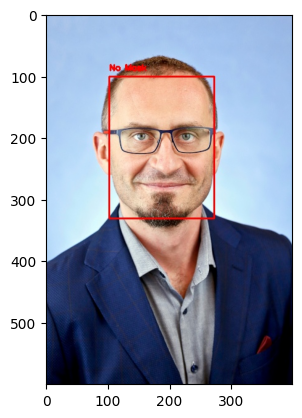

In [28]:
image = cv2.imread(os.path.join(os.getcwd(),'cv2_testing', 'results', 'dziekan1.jpg'))
plt.imshow(image[:, :, ::-1])
plt.show()

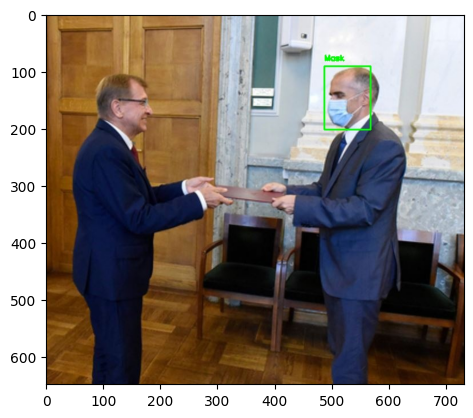

In [29]:
image = cv2.imread(os.path.join(os.getcwd(),'cv2_testing', 'results', 'agh.jpg'))
plt.imshow(image[:, :, ::-1])
plt.show()